In [1]:
# imports
import pandas as pd
import numpy as np
from pdpbox import pdp, info_plots
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
import category_encoders as ce

In [3]:
# load in the dataset -- change filepath as appropriate
df = pd.read_csv(r"C:\Users\Jonat\dat-11-15\ClassMaterial\Unit1\data\restaurant_data\master.csv")

In [4]:
# let's fill in our missing values for now
df = df.fillna(0)

# sort values
df.sort_values(by=['id', 'visit_date'], ascending=True, inplace=True)

# we'll create this column for display purposes
df['city'] = df['area'].str.split('-').str[0]
# create training & test sets
train = df.groupby('id').apply(lambda x: x.iloc[:-15])
test  = df.groupby('id').apply(lambda x: x.iloc[-15:])

# and do our splits
X_train, y_train = train.drop(['visit_date', 'visitors'], axis=1), train['visitors']
X_test, y_test   = test.drop(['visit_date', 'visitors'], axis=1), test['visitors']

In [5]:
# setup our model 
# defining the ordinal encoder to transform day of week in the correct order
ore  = ce.OrdinalEncoder(cols=['day_of_week'], mapping = [
    {'col': 'day_of_week', 'mapping': {
        'Monday': 1,
        'Tuesday': 2,
        'Wednesday': 3,
        'Thursday': 4,
        'Friday': 5,
        'Saturday': 6,
        'Sunday':7
    }}
])

# OneHot Columns That we want to look at
ohe  = ce.OneHotEncoder(cols = ['genre', 'city'], use_cat_names=True)
# creating a pipe with a target encoder to catch everything else
pipe = make_pipeline(ore, ohe, ce.TargetEncoder())
# model to make predictions
mod = GradientBoostingRegressor()
# transform the data and fit
X_train = pipe.fit_transform(X_train, y_train)
mod.fit(X_train, y_train)

GradientBoostingRegressor()

Now, let's build our actual PARTIAL DEPENDENCE PLOT.

In [6]:
X_train

id  day_of_week  holiday  \
id                                                             
air_00a91d42b08b08d9 166836  25.889401            5        0   
                     166837  25.889401            6        0   
                     166838  25.889401            1        0   
                     166839  25.889401            2        0   
                     166840  25.889401            3        0   
...                                ...          ...      ...   
air_fff68b929994bfbd 216629   5.137795            1        0   
                     216630   5.137795            2        0   
                     216631   5.137795            3        0   
                     216632   5.137795            4        0   
                     216633   5.137795            5        0   

                             genre_Italian/French  genre_Izakaya  \
id                                                                 
air_00a91d42b08b08d9 166836                     1              0   
                     166837                     1              0   
                     166838                     1              0   
                     166839                     1              0   
                     166840                     1              0   
...                                           ...            ...   
air_fff68b929994bfbd 216629                     0              0   
                     216630                     0              0   
                     216631                     0              0   
                     216632                     0              0   
                     216633                     0              0   

                             genre_Dining bar  genre_Cafe/Sweets  \
id                                                                 
air_00a91d42b08b08d9 166836                 0                  0   
                     166837                 0                  0   
                     166838                 0                  0   
                     166839                 0                  0   
                     166840                 0                  0   
...                                       ...                ...   
air_fff68b929994bfbd 216629                 0                  0   
                     216630                 0                  0   
                     216631                 0                  0   
                     216632                 0                  0   
                     216633                 0                  0   

                             genre_Japanese food  genre_Western food  \
id                                                                     
air_00a91d42b08b08d9 166836                    0                   0   
                     166837                    0                   0   
                     166838                    0                   0   
                     166839                    0                   0   
                     166840                    0                   0   
...                                          ...                 ...   
air_fff68b929994bfbd 216629                    0                   0   
                     216630                    0                   0   
                     216631                    0                   0   
                     216632                    0                   0   
                     216633                    0                   0   

                             genre_Okonomiyaki/Monja/Teppanyaki  ...  \
id                                                               ...   
air_00a91d42b08b08d9 166836                                   0  ...   
                     166837                                   0  ...   
                     166838                                   0  ...   
                     166839                                   0  ...   
                     166840                                   0 

In [9]:
pdp_day_of_week.pdp

array([16.76561442, 17.96063043, 19.15389374, 19.16153876, 23.23646723,
       25.97618458, 23.7015178 ])

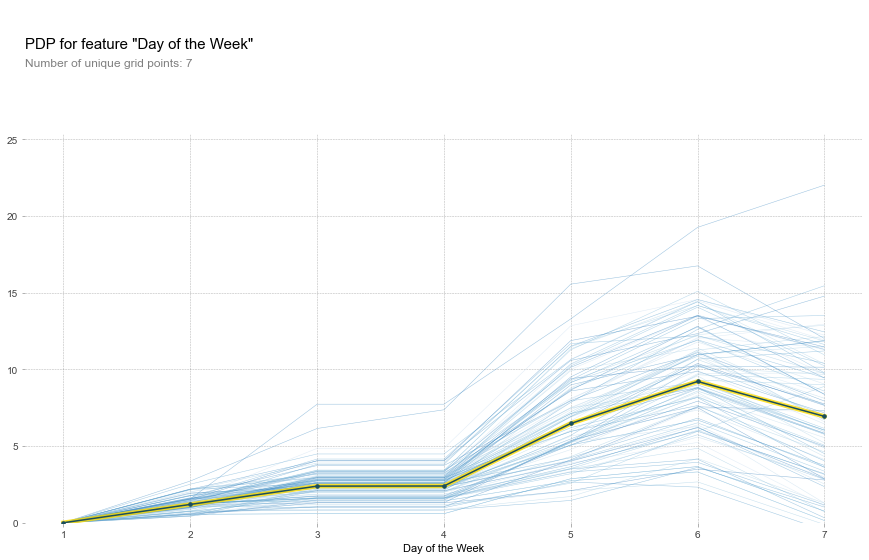

In [8]:
# what was the additive impact of EACH unique value of OverallQual?  What was its marginal impact?
pdp_day_of_week = pdp.pdp_isolate(
    model=mod, dataset=X_train, model_features=X_train.columns.tolist(), 
    feature='day_of_week', cust_grid_points = X_train['day_of_week'].unique().tolist() # use this if you want to plot every unique value
)

fig, axes = pdp.pdp_plot(pdp_day_of_week, 'Day of the Week', plot_lines=True, frac_to_plot=100)

### PDP for OneHot Encoded Columns

Lots of times your categorical data will be one hot encoded.  PDP plots render a bit more naturally if your data is setup this way, so it's a good idea to keep this in mind if you want to run these plots.  Let's setup our model to one hot encode the `genre` column and see how we can get these values to render.

In [11]:
# first, let's grab the columns with genre in them
city_cols = [col for col in X_train.columns if 'city' in col]
city_cols

['city_Tōkyō',
 'city_Ōsaka',
 'city_Hyōgo',
 'city_Hiroshima',
 'city_Fukuoka',
 'city_Hokkaidō Sapporo',
 'city_Miyagi',
 'city_Niigata',
 'city_Hokkaidō Asahikawa',
 'city_Hokkaidō Abashiri',
 'city_Shizuoka',
 'city_Hokkaidō Katō']

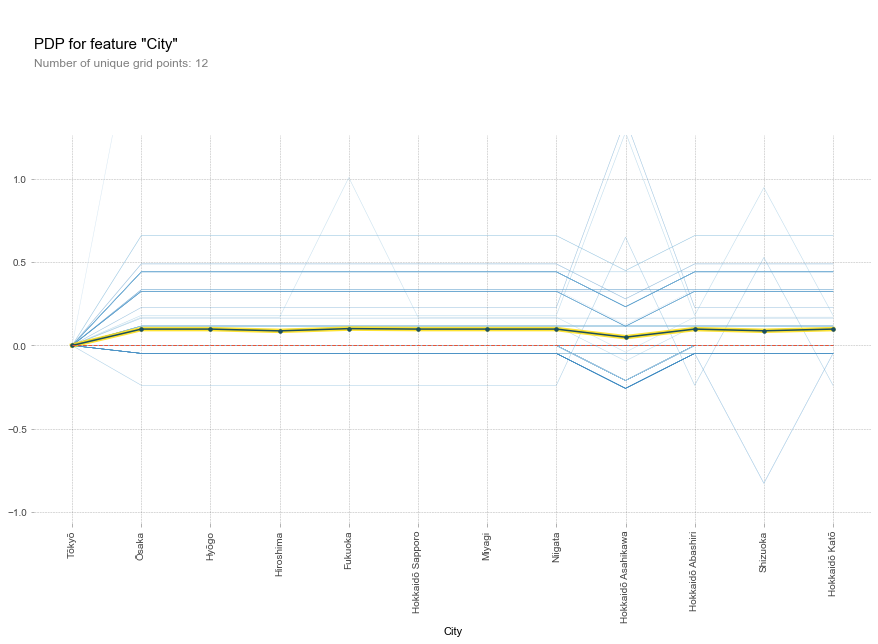

In [12]:
# and what about categorical variables?
# what was the impact of city on attendance?
pdp_city = pdp.pdp_isolate(
    # dataset -- create the final transformation of our data
    model=mod, dataset=X_train, model_features=X_train.columns, 
    # this is the list of all the columns for the genre feature
    feature=city_cols
)

fig, axes = pdp.pdp_plot(pdp_city, 'City', plot_lines=True, frac_to_plot=100)
# this code is just for formatting -- getting the labels to format correctly
xtick_labels = [city.split('_')[1] for city in city_cols]
axes['pdp_ax'].set_xticklabels(xtick_labels, rotation='vertical');

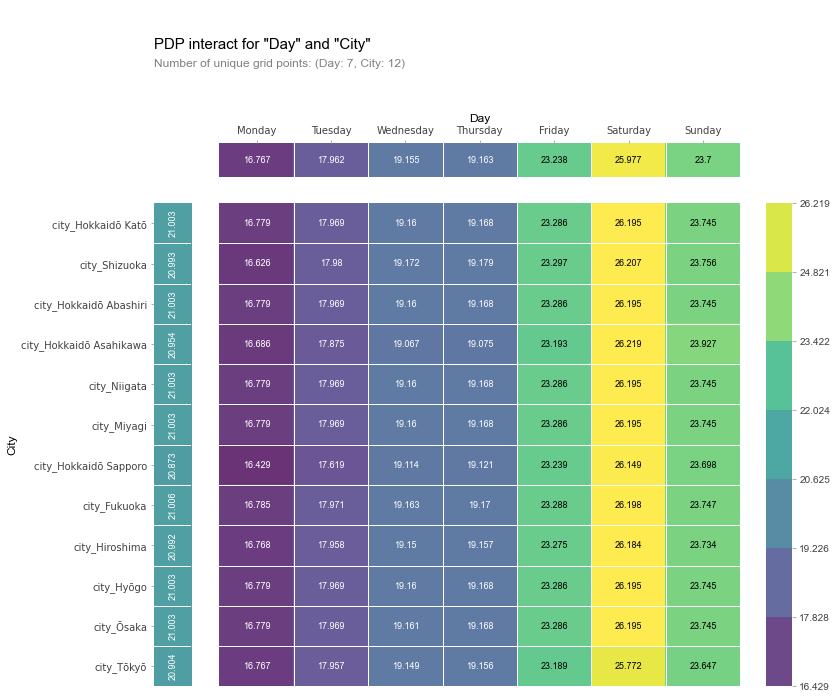

In [12]:
# and a slightly different look at the same problem
gbm_inter = pdp.pdp_interact(
    model=mod, dataset=X_train, model_features=X_train.columns, 
    features=['day_of_week', city_cols]
)


fig, axes = pdp.pdp_interact_plot(
    gbm_inter, ['Day', 'City'], x_quantile=True, plot_type='grid', plot_pdp=True
)

# this part is just for formatting
axes['pdp_inter_ax']['_pdp_inter_ax'].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation='vertical');